<a href="https://colab.research.google.com/github/Supreeta11/Cardiovascular-Risk-Prediction/blob/main/Cardiovascular_Risk_Prediction_Supreeta_kumari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

In [31]:
warnings.filterwarnings('ignore')

In [32]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:

df = pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')

In [36]:
df.info

<bound method DataFrame.info of         id  age  education sex is_smoking  cigsPerDay  BPMeds  \
0        0   64        2.0   F        YES         3.0     0.0   
1        1   36        4.0   M         NO         0.0     0.0   
2        2   46        1.0   F        YES        10.0     0.0   
3        3   50        1.0   M        YES        20.0     0.0   
4        4   64        1.0   F        YES        30.0     0.0   
...    ...  ...        ...  ..        ...         ...     ...   
3385  3385   60        1.0   F         NO         0.0     0.0   
3386  3386   46        1.0   F         NO         0.0     0.0   
3387  3387   44        3.0   M        YES         3.0     0.0   
3388  3388   60        1.0   M         NO         0.0     NaN   
3389  3389   54        3.0   F         NO         0.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    221.0  148.0   85.0    NaN   
1                   0        

In [37]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


In [38]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [39]:
train_df.shape

(2712, 17)

In [40]:
test_df.shape

(678, 17)

In [41]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [42]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_df[cat_features])
train_df[cat_features]= simp_imputer.transform(train_df[cat_features])
test_df[cat_features]= simp_imputer.transform(test_df[cat_features])

In [43]:
train_df.education.unique()

array([2.0, 3.0, 1.0, 4.0], dtype=object)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

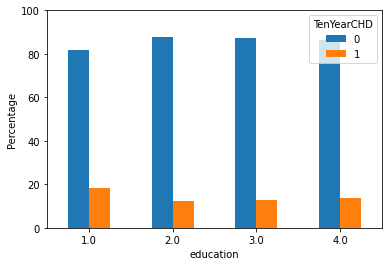

In [44]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [45]:
prob = 0.99
alpha = 1.0 - prob

In [46]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [47]:
cat_dependency(freq_df)

significance=0.010, p=0.0006802
Categorical variables are dependent


True

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

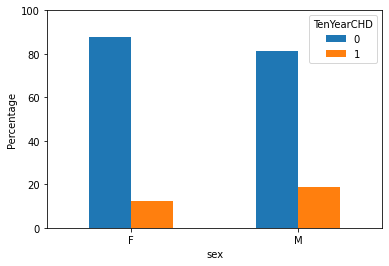

In [48]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [49]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

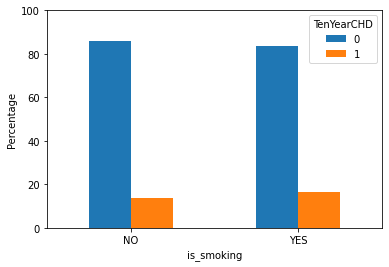

In [50]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [53]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False